In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import itertools
import sklearn
import scipy
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy.spatial.distance import euclidean
import sys
from sklearn.preprocessing import MinMaxScaler
import math
from numpy import array as ndarray

In [102]:
#Import file offense_codes
oc = pd.read_csv (r'https://raw.githubusercontent.com/IndiraInsiyah/Crime-Boston1/master/offense_codes.csv', encoding = "ISO-8859-1")  
print (oc)

     CODE                                       NAME
0     612           LARCENY PURSE SNATCH - NO FORCE 
1     613                        LARCENY SHOPLIFTING
2     615    LARCENY THEFT OF MV PARTS & ACCESSORIES
3    1731                                     INCEST
4    3111                  LICENSE PREMISE VIOLATION
..    ...                                        ...
571  1806  DRUGS - CLASS B TRAFFICKING OVER 18 GRAMS
572  1807  DRUGS - CLASS D TRAFFICKING OVER 50 GRAMS
573  1610    HUMAN TRAFFICKING - COMMERCIAL SEX ACTS
574  2010                              HOME INVASION
575  1620  HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE

[576 rows x 2 columns]


In [103]:
#Import file crimesinboston
cib = pd.read_csv (r'https://raw.githubusercontent.com/IndiraInsiyah/Crime-Boston1/master/crimeinboston.csv', encoding = "ISO-8859-1") 
cib = cib.fillna(0) 
print (cib)

      INCIDENT_NUMBER  OFFENSE_CODE  ...       Long                     Location
0          I182070945           619  ... -71.139371  (42.35779134, -71.13937053)
1          I182070943          1402  ... -71.060300  (42.30682138, -71.06030035)
2          I182070941          3410  ... -71.072429  (42.34658879, -71.07242943)
3          I182070940          3114  ... -71.078664  (42.33418175, -71.07866441)
4          I182070938          3114  ... -71.090361  (42.27536542, -71.09036101)
...               ...           ...  ...        ...                          ...
65502      I182000021           724  ... -71.090898  (42.28976255, -71.09089843)
65503      I182000020          2405  ... -71.048724  (42.35325379, -71.04872410)
65504      I182000019          3301  ... -71.112333  (42.26133580, -71.11233325)
65505      I182000017          3304  ... -71.111603  (42.33225457, -71.11160342)
65506      I182000016          3831  ...   0.000000     (0.00000000, 0.00000000)

[65507 rows x 17 columns]


In [104]:
# Memisahkan Jam dan Tanggal dari kolom 'OCCURRED_ON_DATE' agar dapat dilakukan identifikasi dengan nilai dari Tanggal.
cib[["Tanggal","Waktu"]]=cib['OCCURRED_ON_DATE'].str.split(" ",expand=True)
# Detail data yang akan diolah berjumlah 65507 entri data, bedasarkan kasus tindak kejahatan sepanjang tahun 2018 di Boston.
cib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65507 entries, 0 to 65506
Data columns (total 19 columns):
INCIDENT_NUMBER        65507 non-null object
OFFENSE_CODE           65507 non-null int64
OFFENSE_CODE_GROUP     65507 non-null object
OFFENSE_DESCRIPTION    65507 non-null object
DISTRICT               65507 non-null object
REPORTING_AREA         65507 non-null object
SHOOTING               65507 non-null object
OCCURRED_ON_DATE       65507 non-null object
YEAR                   65507 non-null int64
MONTH                  65507 non-null int64
DAY_OF_WEEK            65507 non-null object
HOUR                   65507 non-null int64
UCR_PART               65507 non-null object
STREET                 65507 non-null object
Lat                    65507 non-null float64
Long                   65507 non-null float64
Location               65507 non-null object
Tanggal                65507 non-null object
Waktu                  65507 non-null object
dtypes: float64(2), int64(4), object(1

In [0]:
def lineplt(x,y,xlabel,ylabel,title,size,tick_spacing):
    fig,ax=plt.subplots(figsize = size)
    plt.plot(x,y)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    plt.xlabel(xlabel,fontsize = 15)
    plt.ylabel(ylabel,fontsize = 15)
    plt.title(title,fontsize = 20)
    plt.show()

# Membuat kolom jumlah kejahatan
def tabel(a1,b1,a2,b2):
    dic = {a1:b1,a2:b2}
    df = pd.DataFrame(dic)
    return df

# Plot histogram
def histogram(d,bin, title):
    plt.figure(figsize=(10,8))
    plt.hist(d, bins=bin)
    plt.title(title, fontsize = 20)
    plt.show()

In [106]:
crime = tabel("TANGGAL",cib["Tanggal"].value_counts().index,"JUMLAH",cib["Tanggal"].value_counts())

# Menampilkan 10 data teratas kejahatan disetiap harinya
crime.head(10)

,TANGGAL,JUMLAH
6/15/2018,6/15/2018,372
5/2/2018,5/2/2018,343
5/23/2018,5/23/2018,339
5/4/2018,5/4/2018,336
6/14/2018,6/14/2018,335
6/25/2018,6/25/2018,331
8/3/2018,8/3/2018,327
6/27/2018,6/27/2018,324
6/7/2018,6/7/2018,323
5/15/2018,5/15/2018,323


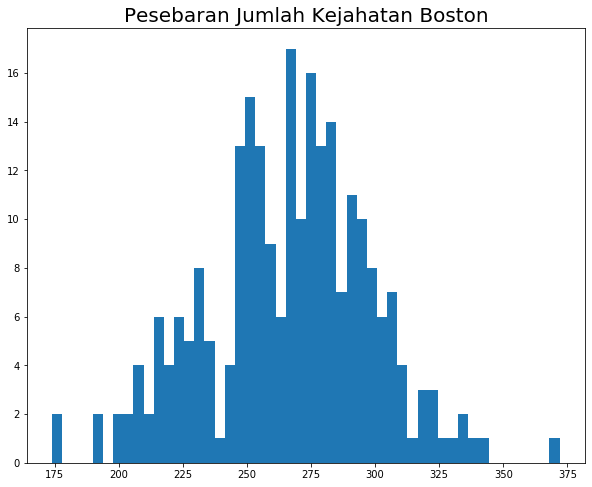

In [107]:
histogram(crime["JUMLAH"],50, "Pesebaran Jumlah Kejahatan Boston")

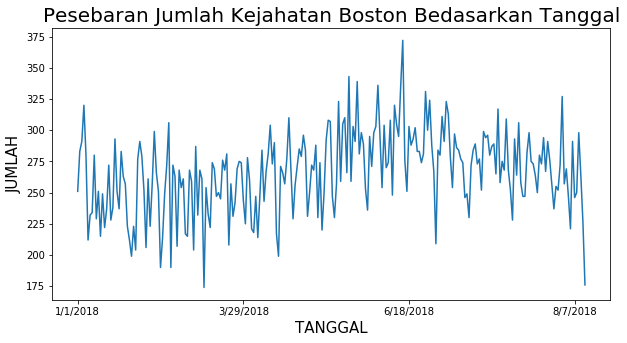

In [108]:
crime = crime.sort_values(by="TANGGAL",ascending = True)
lineplt(crime["TANGGAL"],crime["JUMLAH"],"TANGGAL","JUMLAH","Pesebaran Jumlah Kejahatan Boston Bedasarkan Tanggal",(10,5),80)

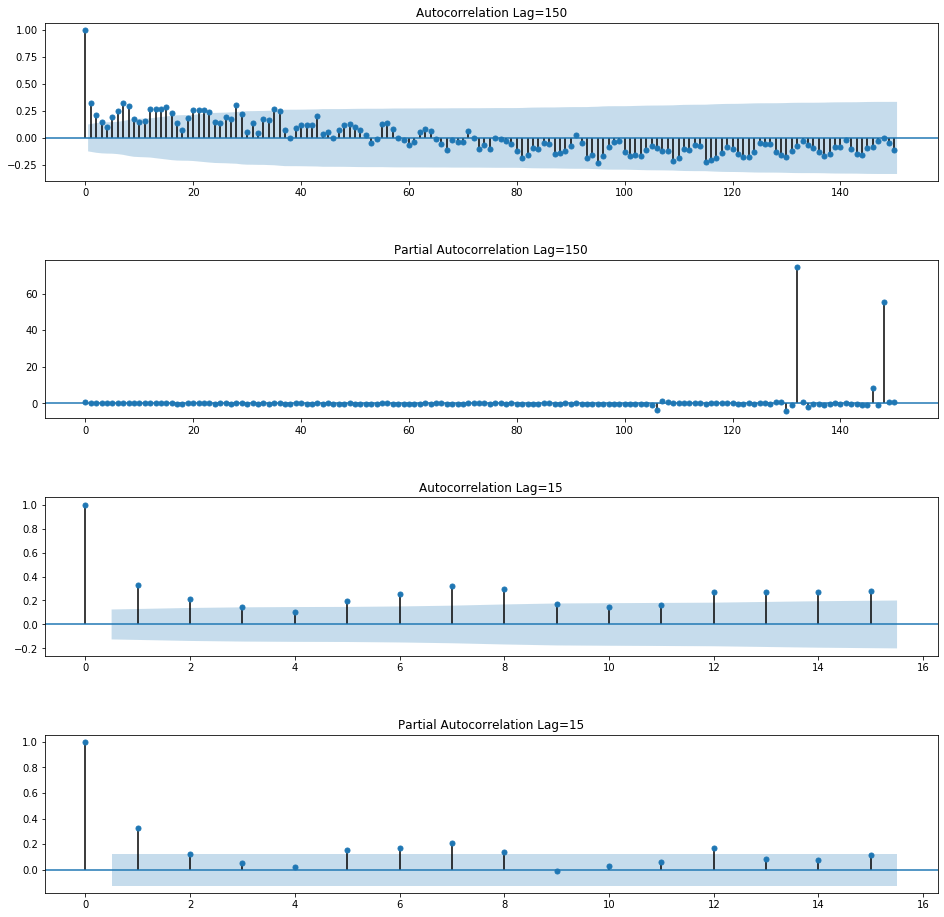

In [109]:
# Mendeskripsikan pesebaran jumlah kejahatan Boston bedasarkan tanggal secara terperinci.
# Menjabarkan detail grafik pesebaran dengan melakukan perlambatan

fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(411)
fig = plot_acf(crime["JUMLAH"],lags=150,ax=ax1)
plt.title('Autocorrelation Lag=150')
ax2 = fig.add_subplot(412)
fig = plot_pacf(crime["JUMLAH"],lags=150,ax=ax2)
plt.title('Partial Autocorrelation Lag=150')
ax3 = fig.add_subplot(413)
fig = plot_acf(crime["JUMLAH"],lags=15,ax=ax3)
plt.title('Autocorrelation Lag=15')
ax4 = fig.add_subplot(414)
fig = plot_pacf(crime["JUMLAH"],lags=15,ax=ax4)
plt.title('Partial Autocorrelation Lag=15')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.show()

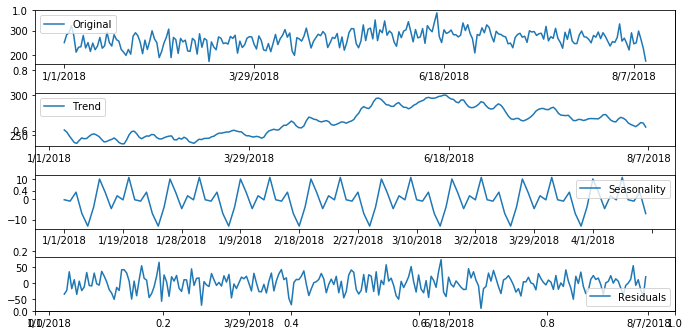

In [110]:
res = sm.tsa.seasonal_decompose(crime['JUMLAH'],freq=12,model="additive")
trend = res.trend
seasonal = res.seasonal
residual = res.resid

fig,ax=plt.subplots(figsize = (10,5))
ax1 = fig.add_subplot(411)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(80))
ax1.plot(crime['JUMLAH'], label='Original')
ax1.legend(loc='best')
ax2 = fig.add_subplot(412)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(80))
ax2.plot(trend, label='Trend')
ax2.legend(loc='best')
ax3 = fig.add_subplot(413)
ax3.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax3.plot(seasonal[:100],label='Seasonality')
ax3.legend(loc='best')
ax4 = fig.add_subplot(414)
ax4.xaxis.set_major_locator(ticker.MultipleLocator(80))
ax4.plot(residual, label='Residuals')
ax4.legend(loc='best')
plt.tight_layout()

In [111]:
def test_stationarity(series,mlag = 100, lag = None,):
    print('ADF Test Result')
    res = adfuller(series, maxlag = mlag, autolag = lag)
    output = pd.Series(res[0:4],index = ['Test Statistic', 'p value', 'used lag', 'Number of observations used'])
    for key, value in res[4].items():
        output['Critical Value ' + key] = value
    print(output)
test_stationarity(crime['JUMLAH'],lag = 'AIC')

ADF Test Result
Test Statistic                  -2.787879
p value                          0.060026
used lag                         6.000000
Number of observations used    239.000000
Critical Value 1%               -3.458011
Critical Value 5%               -2.873710
Critical Value 10%              -2.573256
dtype: float64


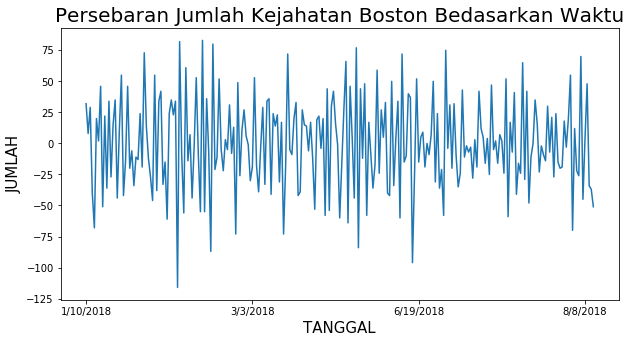

Average= -0.30612244897959184
Std= 37.021374022220485
SE= 2.365208826689423
ADF Test Result
Test Statistic                -1.129524e+01
p value                        1.348783e-20
used lag                       6.000000e+00
Number of observations used    2.380000e+02
Critical Value 1%             -3.458128e+00
Critical Value 5%             -2.873762e+00
Critical Value 10%            -2.573283e+00
dtype: float64
None


In [112]:
d1 = crime.copy()
d1['JUMLAH'] = d1['JUMLAH'].diff(1)
d1 = d1.dropna()
lineplt(d1["TANGGAL"],d1["JUMLAH"],"TANGGAL","JUMLAH","Persebaran Jumlah Kejahatan Boston Bedasarkan Waktu",(10,5),80)
print('Average= '+str(d1['JUMLAH'].mean()))
print('Std= ' + str(d1['JUMLAH'].std()))
print('SE= ' + str(d1['JUMLAH'].std()/math.sqrt(len(d1))))
print(test_stationarity(d1['JUMLAH'],lag = 'AIC'))

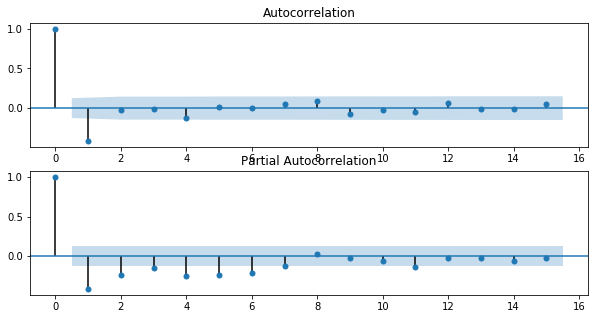

In [113]:
fig_2 = plt.figure(figsize=(10,5))
ax1_2 = fig_2.add_subplot(211)
fig_2 = plot_acf(d1["JUMLAH"],lags=15,ax=ax1_2)
ax2_2 = fig_2.add_subplot(212)
fig_2 = plot_pacf(d1["JUMLAH"],lags=15,ax=ax2_2)

In [114]:
timeseries = crime['JUMLAH']
p,d,q = (4,1,2)
arima_mod = ARIMA(timeseries,(p,d,q)).fit()
summary = (arima_mod.summary2(alpha=.05, float_format="%.8f"))
print(summary)

                          Results: ARIMA
Model:              ARIMA            BIC:                 2378.9102
Dependent Variable: D.JUMLAH         Log-Likelihood:      -1167.5  
Date:               2019-12-16 04:17 Scale:               1.0000   
No. Observations:   245              Method:              css-mle  
Df Model:           7                Sample:              1        
Df Residuals:       238                                   6        
Converged:          1.0000           S.D. of innovations: 28.268   
No. Iterations:     20.0000          HQIC:                2362.180 
AIC:                2350.9002                                      
--------------------------------------------------------------------
                 Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
--------------------------------------------------------------------
const           -0.0064    0.1651  -0.0387  0.9692  -0.3299   0.3172
ar.L1.D.JUMLAH   0.3304    0.2648   1.2477  0.2134  -0.1886   0.8494
ar

In [0]:
from datetime import datetime, timedelta

start_date = datetime.strptime('2018-01-01','%Y-%m-%d')
start_date = timedelta(minutes = start_date.minute % 5, seconds = start_date.second % 60)
end_date = start_date + timedelta(minutes=30)

arima_mod = sm.tsa.ARIMA(timeseries, order=(5,0,1), freq = cib(minutes=5), missing = 'drop').fit()
arima_mod.predict(start_date, end_date, dynamic=True) # fails
arima_mod.predict(start_date.__str__(), end_date.__str__(), dynamic=False)
predict_data = arima_mod.predict(start='2018-01-01', end='2018-09-03', dynamic = False)
timeseries.index = pd.DatetimeIndex(timeseries.index)
fig, ax = plt.subplots(figsize=(20, 15))
ax = timeseries.plot(ax=ax)
predict_data.plot(ax=ax)
plt.show()



In [0]:
p = d = q = range(0, 2)
 
# Membuat kombinasi berdeba untuk nilai p, d dan q
pdq = list(itertools.product(p, d, q))
 
# Membuat kombinasi berbeda untuk nilai seasonal p, d ,q dan 7. Nilai 7 untuk periode hari dalam 1 minggu.
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [0]:
res = pd.DataFrame(columns = ['order', 'seasonal_order', 'AIC'])

In [71]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(crime['JUMLAH'],order=param,seasonal_order=param_seasonal) 
            results = mod.fit()
            data = {'order': param, 'seasonal_order': param_seasonal, 'AIC':results.aic}
            res = res.append(data,ignore_index=True)
        except:
            continue
res = res.sort_values(by = 'AIC', ascending = True)
print(res.head(5))

        order seasonal_order          AIC
27  (0, 1, 1)   (0, 1, 1, 7)  2284.353577
59  (1, 1, 1)   (0, 1, 1, 7)  2286.202742
31  (0, 1, 1)   (1, 1, 1, 7)  2286.304914
43  (1, 0, 1)   (0, 1, 1, 7)  2288.072394
63  (1, 1, 1)   (1, 1, 1, 7)  2288.132790


In [72]:
model=SARIMAX(crime['JUMLAH'], order=(1,1,1), seasonal_order=(1,1,1, 7)).fit()
summary = model.summary()
print(summary)

                                 Statespace Model Results                                
Dep. Variable:                            JUMLAH   No. Observations:                  246
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1139.066
Date:                           Mon, 16 Dec 2019   AIC                           2288.133
Time:                                   04:02:04   BIC                           2305.494
Sample:                                        0   HQIC                          2295.130
                                           - 246                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0292      0.081      0.362      0.717      -0.129       0.187
ma.L1         -0.9128      0.042    -21.768

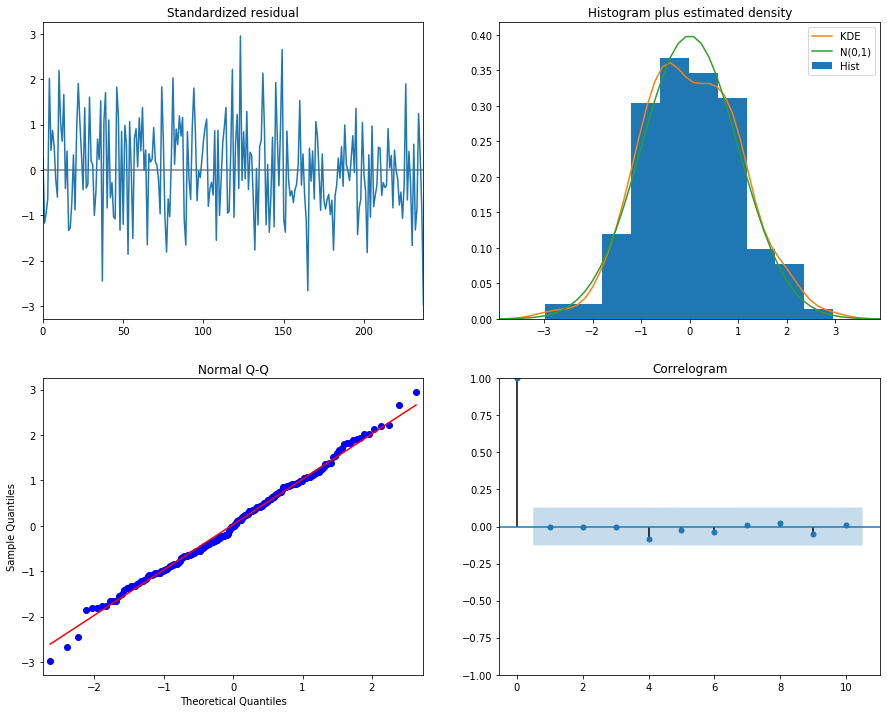

In [73]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [0]:
predict_data = arima_mod.predict(start='2018-01-01', end='2018-12-30', dynamic = False)
timeseries.index = pd.DatetimeIndex(timeseries.index)
fig, ax = plt.subplots(figsize=(20, 15))
ax = timeseries.plot(ax=ax)
predict_data.plot(ax=ax)
plt.show()

In [0]:
# Prediksi 30 hari kedapan
pred_uc = model.get_forecast(steps=30)

# Interval prediksi
pred_ci = pred_uc.conf_int()

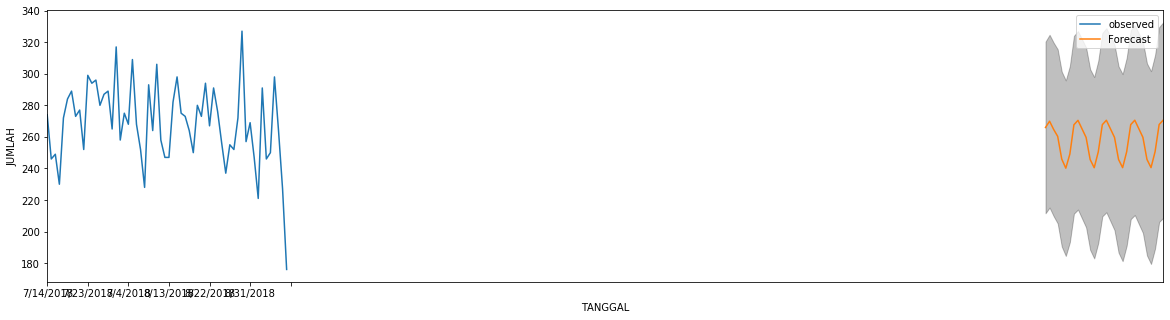

In [77]:
ax = crime['JUMLAH'][-60:].plot(label='observed', figsize=(20, 5))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('TANGGAL')
ax.set_ylabel('JUMLAH')
 
plt.legend()
plt.show()

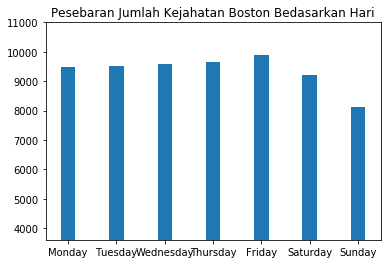

In [59]:
week = tabel("Week",cib["DAY_OF_WEEK"].value_counts().index,"JUMLAH",cib["DAY_OF_WEEK"].value_counts())
week=week.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.bar(week["Week"] , week["JUMLAH"], width=0.3)
plt.ylim(3600, 11000)
plt.title('Pesebaran Jumlah Kejahatan Boston Bedasarkan Hari')
plt.show()

In [78]:
print(cib["DISTRICT"].unique())

['D14' 'C11' 'D4' 'B3' 'B2' 'C6' 0 'A1' 'E5' 'A7' 'E13' 'E18' 'A15']


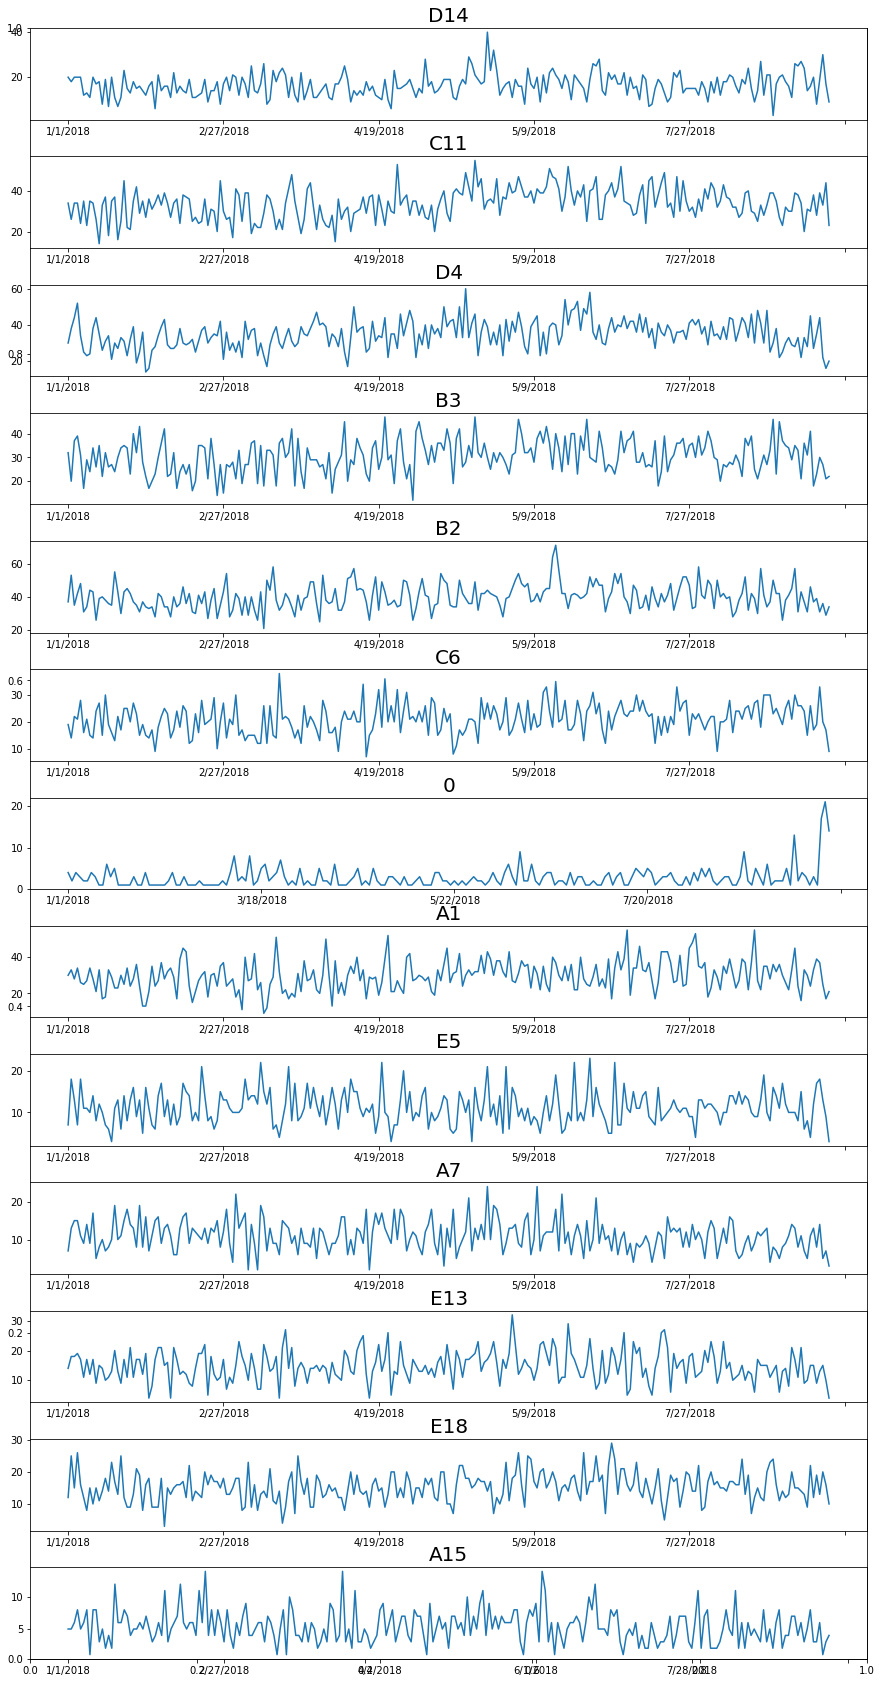

In [80]:
fig,ax = plt.subplots(figsize =(15,30))
i = 0
for dis in cib["DISTRICT"].unique():
    if dis is not np.nan :
        i += 1
        da = cib[cib["DISTRICT"] == dis]
        d = tabel("TANGGAL",da["Tanggal"].value_counts().index,"JUMLAH",da["Tanggal"].value_counts())
        d = d.sort_values(by="TANGGAL",ascending = True)
        fig.add_subplot(13,1,i)
        plt.plot(d["TANGGAL"],d["JUMLAH"])     
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.4)
        ax=plt.gca()
        ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
        plt.title(dis,fontsize = 20)
plt.show()